In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train.csv']


Analysis

Data Exploration

We are going to load the entire data in memory even though the dataset is fairly large. This is being done so that we can run some analysis on the original dataset.

In [2]:
%%time
train = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 2s, sys: 8.18 s, total: 2min 11s
Wall time: 2min 11s


In [3]:
print(train.shape)
print(train.head())

(629145480, 2)
   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691


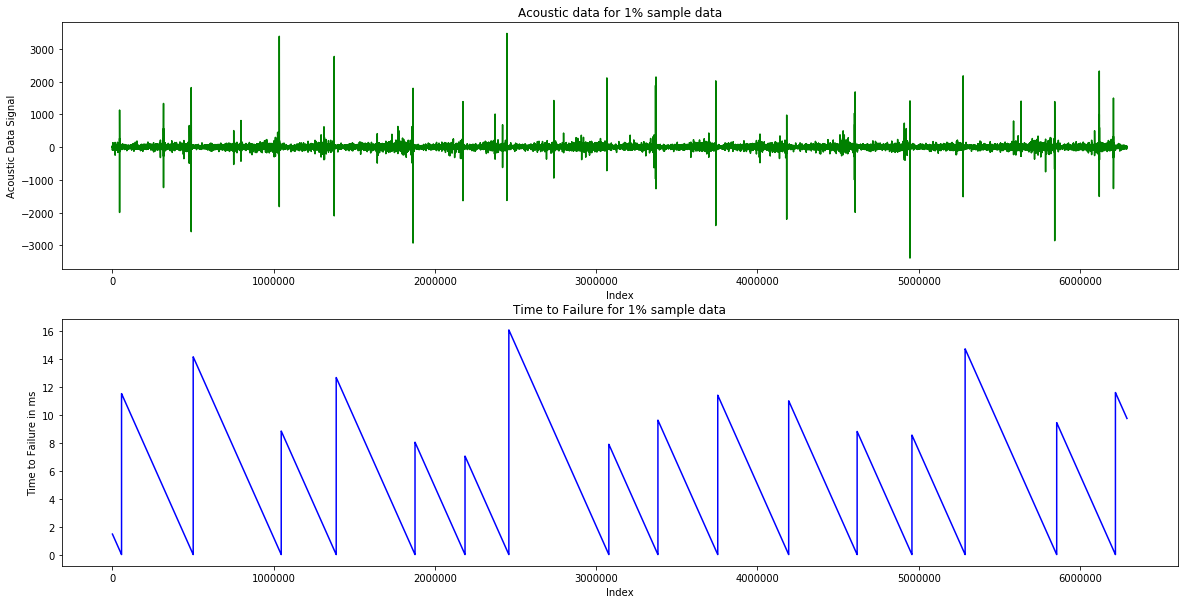

In [4]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(train['acoustic_data'].values[::100], color='g')
ax[0].set_title("Acoustic data for 1% sample data")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Acoustic Data Signal");
ax[1].plot(train['time_to_failure'].values[::100], color='b')
ax[1].set_title("Time to Failure for 1% sample data")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Time to Failure in ms");

Exploratory Visualization

Looking at the above Time To Failure plot, we see that there are 16 earthquakes that occur (Time To Failue = 0). We can explore those specific points of earthquakes further in the next few plots, by investigating each of the quake points further by taking an approximate sample of 30,000,000 consecutive points (in steps of 50, so 2% of the 30,000,000 points) during which the quake occurs.

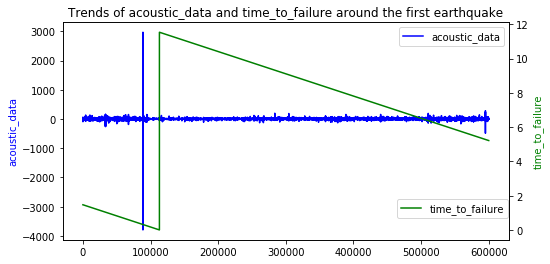

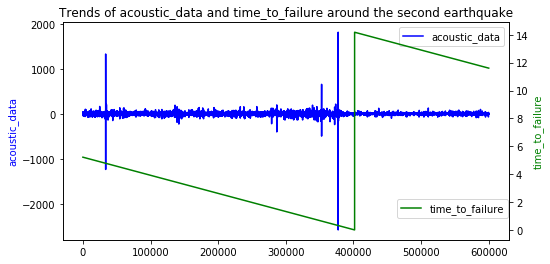

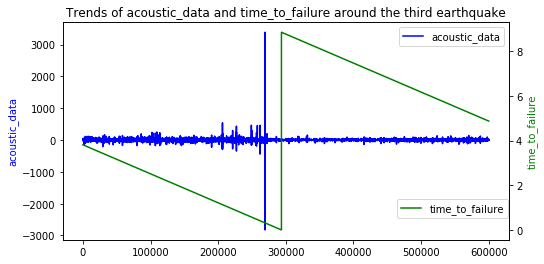

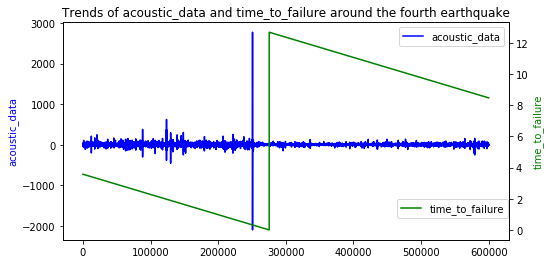

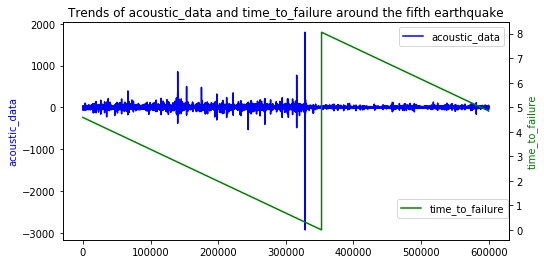

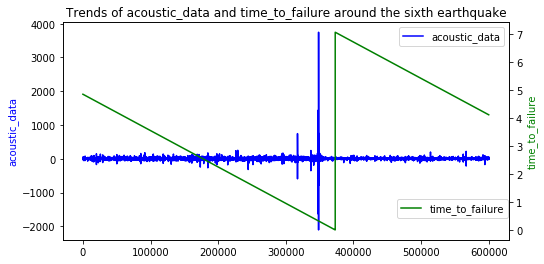

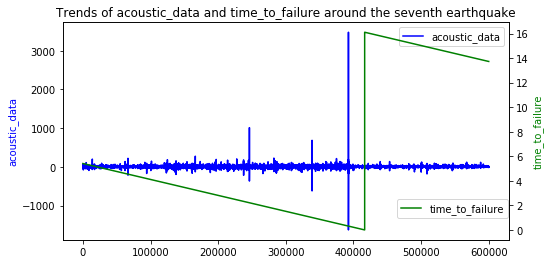

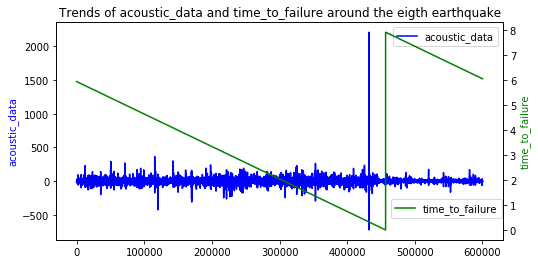

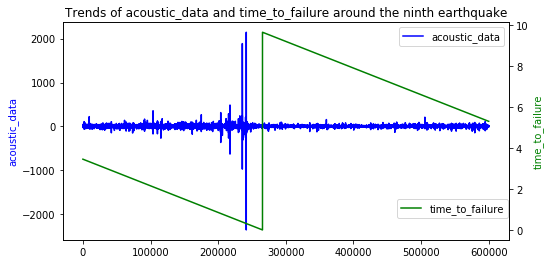

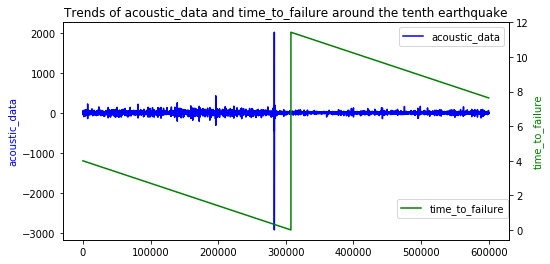

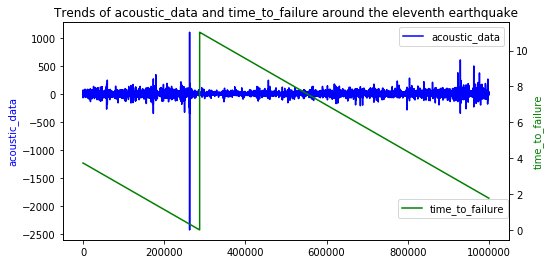

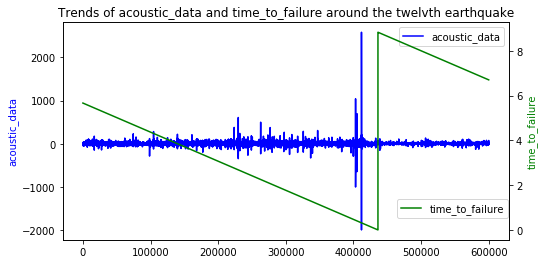

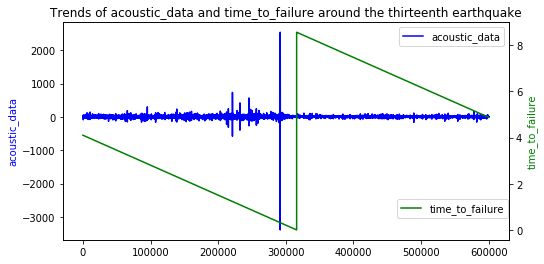

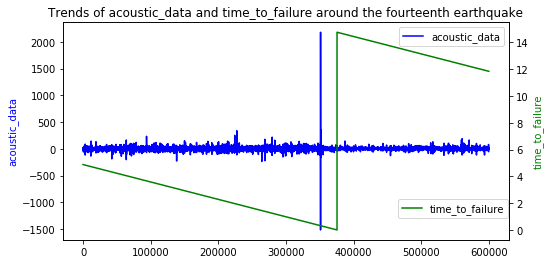

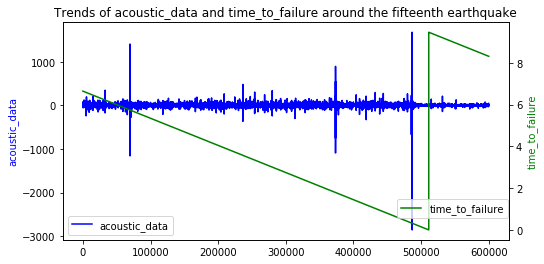

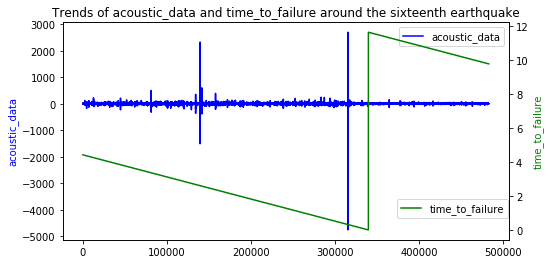

In [5]:
def plotAroundPoints(start, end, ith):
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data and time_to_failure around the {} earthquake".format(ith))
    plt.plot(train['acoustic_data'].values[start:end:50], color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])
    ax2 = ax1.twinx()
    plt.plot(train['time_to_failure'].values[start:end:50], color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend(['time_to_failure'], loc=(0.75, 0.1))

plotAroundPoints(0, 30000000, "first")
plotAroundPoints(30000000, 60000000, "second")
plotAroundPoints(90000000, 120000000, "third")
plotAroundPoints(125000000, 155000000, "fourth")
plotAroundPoints(170000000, 200000000, "fifth")
plotAroundPoints(200000000, 230000000, "sixth")
plotAroundPoints(225000000, 255000000, "seventh")
plotAroundPoints(285000000, 315000000, "eigth")
plotAroundPoints(325000000, 355000000, "ninth")
plotAroundPoints(360000000, 390000000, "tenth")
plotAroundPoints(405000000, 455000000, "eleventh")
plotAroundPoints(440000000, 470000000, "twelvth")
plotAroundPoints(480000000, 510000000, "thirteenth")
plotAroundPoints(510000000, 540000000, "fourteenth")
plotAroundPoints(560000000, 590000000, "fifteenth")
plotAroundPoints(605000000, 635000000, "sixteenth")


Observing the above plots, we can thus conclude that there always is a big spike in the acoustic signal value just before the earthquake. This could be useful information and can be used as a random visual verification metric (as a secondary form of verification, in addition to our metric scores) once our model has been implemented.

We also need to look at the provided test data folder, which contain the `acoustic_data` column against which we need to predict the `time_to_failure` values.

In [6]:
test_dir = "../input/test"
test_files = os.listdir(test_dir)
print(test_files[0:5])
print("Number of test files: {}".format(len(test_files)))
test_file_0 = pd.read_csv('../input/test/' + test_files[0])
print("Dimensions of the first test file: {}".format(test_file_0.shape))
test_file_0.head()

['seg_d3bb14.csv', 'seg_7a09ec.csv', 'seg_3cbccf.csv', 'seg_53498a.csv', 'seg_1f3d44.csv']
Number of test files: 2624
Dimensions of the first test file: (150000, 1)


,acoustic_data
0,-13
1,-8
2,-10
3,-9
4,-6


Finally, we also need to check the submission file which needs to be populated with our predictions.

In [57]:
submission = pd.read_csv("../input/sample_submission.csv", dtype={"time_to_failure": np.float32})
submission.head()

,seg_id,time_to_failure
0,seg_00030f,0.0
1,seg_0012b5,0.0
2,seg_00184e,0.0
3,seg_003339,0.0
4,seg_0042cc,0.0


In [8]:
len(submission)

2624

This verifies that there are `2624` rows in the `sample_submission.csv` file, which corresponds to the number of the test files in the test folder. We need to provide a value for the `time_to_failure` column in the `sample_submission.csv` file, each row of the file coinciding with a test file containing `150,000` values for the `acoustic_data` column.

Algorithms and Techniques

Looking at the nature of the data, the following algorithms could be tried to determinepatterns in the test data (data in the test folder) that match the data in thetraining set (some or all may be implemented):
* Polynomial Regression  
  Since the nature of the data is non-linear, I am going to try a Polynomial Regression model to check how the model performs against the given data. I am also going to use L2 regularisation with a small lambda value to not overly punish the model.
* Neural Network
  I am also going to try to use a Neural Network model as the data is non-linear.

Benchmark

Let us try to use a Linear Regression model to fit the training data and compute a Mean Absolute Error (MAE) score, so that we can get a benchmark against a simple model. Since the data set is massive, and is contiguous in nature, we will take a sample of the entire data i.e. 2% and try to derive a linear regression model on it.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

X_train, X_test, y_train, y_test = train_test_split(train['acoustic_data'].values[::25].reshape(-1, 1), train['time_to_failure'].values[::25], test_size=0.2)

quake_linear_model = LinearRegression()
quake_linear_model.fit(X_train, y_train)

y_train_pred = quake_linear_model.predict(X_train)
y_test_pred = quake_linear_model.predict(X_test)

r2_train_score = r2_score(y_train, y_train_pred)
mae_train_score = median_absolute_error(y_train, y_train_pred)
r2_test_score = r2_score(y_test, y_test_pred)
mae_test_score = median_absolute_error(y_test, y_test_pred)

print("R2 score for training data: {} and for the test data: {}".format(r2_train_score, r2_test_score))
print("Mean Absolute Error score for training data: {} and for the test data: {}".format(mae_train_score, mae_test_score))

R2 score for training data: 4.190664655290277e-07 and for the test data: -8.021766673138586e-08
Mean Absolute Error score for training data: 2.8042475637091644 and for the test data: 2.8065586342498103


**III Methodology**

**Data Preprocessing**

Firstly, we need to add some more features to this data set, which contains only 1 column for the input signal.

This can be done by generating statistical information over chunks of the original dataset of length 150,000. This is the length of the test files that we need to make the predictions for. (Ref: Basic Feature Benchmark by Inversion: https://www.kaggle.com/inversion/basic-feature-benchmark)



In [10]:
chunk_size = 150000

chunks = int(np.floor(train.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [11]:
for chunk_no in tqdm(range(chunks)):
    data_chunk = train.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████| 4194/4194 [00:46<00:00, 88.56it/s]


In [12]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()

(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0



**Implementation**

Now that we have created a new dataset with additional features, the next step is to divide this new dataset into training and test sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape

(3355, 11)

Next, we shall try and build a RNN (Recurrent Neural Network) model with Keras, as the training data is sequential in nature. 

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNGRU, CuDNNLSTM, Flatten
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

model = Sequential()
# model.add(CuDNNLSTM(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 64)                12864     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [15]:
from keras.callbacks import ModelCheckpoint

# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
model.compile(loss="mean_absolute_error", optimizer="rmsprop", metrics=["mae"])

checkpointer = ModelCheckpoint("model.weights.hdf5", save_best_only=True, verbose=1)

build = model.fit(X_train_array, y_train, epochs=200, batch_size=30, validation_split = 0.20, callbacks=[checkpointer], verbose=1)

Train on 2684 samples, validate on 671 samples
Epoch 1/200
2684/2684 [==============================] - 3s 1ms/step - loss: 3.2577 - mean_absolute_error: 3.2577 - val_loss: 2.6128 - val_mean_absolute_error: 2.6128

Epoch 00001: val_loss improved from inf to 2.61278, saving model to model.weights.hdf5
Epoch 2/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.8744 - mean_absolute_error: 2.8744 - val_loss: 2.5338 - val_mean_absolute_error: 2.5338

Epoch 00002: val_loss improved from 2.61278 to 2.53383, saving model to model.weights.hdf5
Epoch 3/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.7238 - mean_absolute_error: 2.7238 - val_loss: 2.3680 - val_mean_absolute_error: 2.3680

Epoch 00003: val_loss improved from 2.53383 to 2.36804, saving model to model.weights.hdf5
Epoch 4/200
2684/2684 [==============================] - 0s 149us/step - loss: 2.5715 - mean_absolute_error: 2.5715 - val_loss: 2.4037 - val_mean_absolute_error: 2.4037

Epoch 

2684/2684 [==============================] - 0s 147us/step - loss: 2.2451 - mean_absolute_error: 2.2451 - val_loss: 2.1591 - val_mean_absolute_error: 2.1591

Epoch 00036: val_loss improved from 2.15914 to 2.15906, saving model to model.weights.hdf5
Epoch 37/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.2209 - mean_absolute_error: 2.2209 - val_loss: 2.3296 - val_mean_absolute_error: 2.3296

Epoch 00037: val_loss did not improve from 2.15906
Epoch 38/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.2398 - mean_absolute_error: 2.2398 - val_loss: 2.2163 - val_mean_absolute_error: 2.2163

Epoch 00038: val_loss did not improve from 2.15906
Epoch 39/200
2684/2684 [==============================] - 0s 149us/step - loss: 2.2342 - mean_absolute_error: 2.2342 - val_loss: 2.1823 - val_mean_absolute_error: 2.1823

Epoch 00039: val_loss did not improve from 2.15906
Epoch 40/200
2684/2684 [==============================] - 0s 148us/step - loss: 2.253

2684/2684 [==============================] - 0s 147us/step - loss: 2.2032 - mean_absolute_error: 2.2032 - val_loss: 2.1584 - val_mean_absolute_error: 2.1584

Epoch 00072: val_loss did not improve from 2.14450
Epoch 73/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1937 - mean_absolute_error: 2.1937 - val_loss: 2.3018 - val_mean_absolute_error: 2.3018

Epoch 00073: val_loss did not improve from 2.14450
Epoch 74/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.2073 - mean_absolute_error: 2.2073 - val_loss: 2.1917 - val_mean_absolute_error: 2.1917

Epoch 00074: val_loss did not improve from 2.14450
Epoch 75/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1920 - mean_absolute_error: 2.1920 - val_loss: 2.1455 - val_mean_absolute_error: 2.1455

Epoch 00075: val_loss did not improve from 2.14450
Epoch 76/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1742 - mean_absolute_error: 2.1742 - val_lo

2684/2684 [==============================] - 0s 145us/step - loss: 2.2086 - mean_absolute_error: 2.2086 - val_loss: 2.2538 - val_mean_absolute_error: 2.2538

Epoch 00108: val_loss did not improve from 2.12820
Epoch 109/200
2684/2684 [==============================] - 0s 149us/step - loss: 2.1718 - mean_absolute_error: 2.1718 - val_loss: 2.1401 - val_mean_absolute_error: 2.1401

Epoch 00109: val_loss did not improve from 2.12820
Epoch 110/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1911 - mean_absolute_error: 2.1911 - val_loss: 2.1340 - val_mean_absolute_error: 2.1340

Epoch 00110: val_loss did not improve from 2.12820
Epoch 111/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.1849 - mean_absolute_error: 2.1849 - val_loss: 2.1290 - val_mean_absolute_error: 2.1290

Epoch 00111: val_loss did not improve from 2.12820
Epoch 112/200
2684/2684 [==============================] - 0s 148us/step - loss: 2.1651 - mean_absolute_error: 2.1651 - va

2684/2684 [==============================] - 0s 148us/step - loss: 2.1642 - mean_absolute_error: 2.1642 - val_loss: 2.1334 - val_mean_absolute_error: 2.1334

Epoch 00145: val_loss did not improve from 2.12820
Epoch 146/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.1472 - mean_absolute_error: 2.1472 - val_loss: 2.1696 - val_mean_absolute_error: 2.1696

Epoch 00146: val_loss did not improve from 2.12820
Epoch 147/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.1550 - mean_absolute_error: 2.1550 - val_loss: 2.1439 - val_mean_absolute_error: 2.1439

Epoch 00147: val_loss did not improve from 2.12820
Epoch 148/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1438 - mean_absolute_error: 2.1438 - val_loss: 2.1444 - val_mean_absolute_error: 2.1444

Epoch 00148: val_loss did not improve from 2.12820
Epoch 149/200
2684/2684 [==============================] - 0s 146us/step - loss: 2.1511 - mean_absolute_error: 2.1511 - va


Epoch 00181: val_loss did not improve from 2.12455
Epoch 182/200
2684/2684 [==============================] - 0s 148us/step - loss: 2.1477 - mean_absolute_error: 2.1477 - val_loss: 2.1556 - val_mean_absolute_error: 2.1556

Epoch 00182: val_loss did not improve from 2.12455
Epoch 183/200
2684/2684 [==============================] - 0s 145us/step - loss: 2.1411 - mean_absolute_error: 2.1411 - val_loss: 2.1510 - val_mean_absolute_error: 2.1510

Epoch 00183: val_loss did not improve from 2.12455
Epoch 184/200
2684/2684 [==============================] - 0s 145us/step - loss: 2.1592 - mean_absolute_error: 2.1592 - val_loss: 2.1298 - val_mean_absolute_error: 2.1298

Epoch 00184: val_loss did not improve from 2.12455
Epoch 185/200
2684/2684 [==============================] - 0s 147us/step - loss: 2.1640 - mean_absolute_error: 2.1640 - val_loss: 2.1586 - val_mean_absolute_error: 2.1586

Epoch 00185: val_loss did not improve from 2.12455
Epoch 186/200
2684/2684 [==============================]

In [16]:
print(build.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


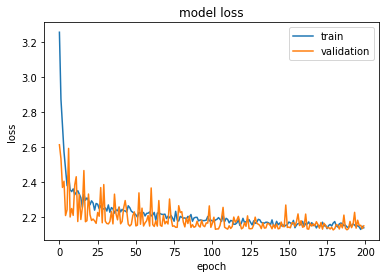

In [17]:
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
predictions = model.predict(X_train_array)

r2_pred_score = r2_score(y_train, predictions)
mae_pred_score = median_absolute_error(y_train, predictions)

print("R2 score for training data: {}".format(r2_pred_score))
print("Mean Absolute Error score for training data: {}".format(mae_pred_score))

R2 score for training data: 0.44329543542119465
Mean Absolute Error score for training data: 1.6231203079223633


In [19]:
X_test_array = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predictions_test = model.predict(X_test_array)

r2_pred_test_score = r2_score(y_test, predictions_test)
mae_pred_test_score = median_absolute_error(y_test, predictions_test)

print("R2 score for test data: {}".format(r2_pred_test_score))
print("Mean Absolute Error score for test data: {}".format(mae_pred_test_score))

R2 score for test data: 0.4197401730815473
Mean Absolute Error score for test data: 1.6654088497161865


**Refinement**

As mentioned above, RNN was selected as the model (RNN layers) given the nature of the data. 
The various layers available in RNN (Keras) are: 
* RNN
* GRU
* LSTM
* CuDNNGRU
* CuDNNLSTM
etc.

The first model was implemented using the following parameter values:
* epochs = 30
* Number of units in the Dense layers = 32
* Dropout probability of 0.1
* CuDNNLSTM as in the input layer for the RNN implementation in Keras

These parameters were then continually refined to obtain better results: 
* The results obtained using these parameters were good with mean validation loss (mean squared error) around 7.85. The number of epochs were then incrementally increased, which kept reducing the validation loss and hence the number of epochs were then finally set to 200 as increasing the epochs further did not result in further improvement over the validation loss, causing overfitting.
* The number of units in the Dense layers of the network were increased to 64, which also improved the model results with a lower validation loss.
* Increase in the Dropout value from 0.1 to 0.2 also yielded better results.
* And finally, switching the *CuDNNLSTM* input layer with *CuDNNGRU* implementation further improved the result.


**Results**

**Model Evaluation and Validation**

Once we built our final model, we plotted a learning curve for the validation loss over the training and validation sets (refer to Figure).

This plot shows that the training loss reduces continually with the validation loss closely following the training loss. This trend in the loss plot confirms a good fit of our model.

**Justification**

R2 score for training data: 2.9657491629198063e-07 and for the test data: 4.92912790694966e-07
Mean Absolute Error score for training data: 2.804914134725992 and for the test data: 2.8038857678803177

Lets tabulate our final results in terms of the metrics i.e. the R2 score and the Mean Absolute Error against the benchmark of our sample data.

____________________________________________________________________________
|    |Training Set Score Benchmark/Final  | Test Set Score Benchmark/Final |
|____|____________________________________|________________________________|
| R2 | 2.9657e-07/0.4471                  | 4.9291e-07/0.4147              |
|____|____________________________________|________________________________|
| MAE| 2.8049/1.6096                      | 2.8038/1.6573                  |
____________________________________________________________________________

Looking at the comparison of the benchmark vs the implemented model metrics, there is a massive improvement for the R2 score of our final model over the benchmark model, as well as a big reduction in the mean absolute error as well. This comparison gives us confidence in the implemented model to predict results for the given test set (different from the test set used above).


**V. Conclusion**

**Free Form Visualization**

In [20]:
X_sub = pd.DataFrame(columns=X_data.columns, dtype=np.float32)

for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('../input/test/' + str(seg_id) + '.csv')
    X_seg = create_features(seg, X_sub, i)
    # print(X_seg)
    # X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
    # pred_seg = model.predict(X_seg_array)
    # print(pred_seg)
    # submission.time_to_failure[i] = pred_seg

100%|██████████| 2624/2624 [01:19<00:00, 32.02it/s]


In [21]:
print(X_sub.shape)
X_sub.head()

(2624, 11)


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-75.0,115.0,4.893690,4.491780,673767.0,4.0,0.000027,-2.0,2.0,7.0,11.0
1,-140.0,152.0,5.922840,4.171154,625673.0,4.0,-0.000013,-2.0,2.0,7.0,11.0
2,-193.0,248.0,6.946990,4.610260,691539.0,5.0,-0.000020,-2.0,2.0,7.0,11.0
3,-93.0,85.0,4.114147,4.531473,679721.0,5.0,0.000047,-1.0,3.0,7.0,10.0
4,-147.0,177.0,5.797163,4.128340,619251.0,4.0,-0.000007,-2.0,2.0,6.0,10.0


In [58]:
X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
pred_final = model.predict(X_seg_array)
submission['time_to_failure'] = pred_final
submission.head()

,seg_id,time_to_failure
0,seg_00030f,5.070074
1,seg_0012b5,5.155626
2,seg_00184e,4.990634
3,seg_003339,7.777793
4,seg_0042cc,7.505665


In [59]:
submission.to_csv('submission.csv')

After running the predictions on the test files using the model implemented, we generate an output submission.csv by outputting the time_to_failure values against each test file. 

Furthermore, on doing a simple search for all the time_to_failure values that are <1.0, we get a list of the following test files and their predicted time_to_failure values:

|seg_26a2a0|0.88940096|
|__________|__________|
|seg_724df9|0.61797214|
|seg_7a9f2b|0.92327976|
|seg_7fa6ec|0.96871   |
|seg_aa98cc|0.8351287 |
|seg_c80857|0.6413747 |
|seg_e3d751|0.8323933 |

We next plot the acoustic_data values for each of these files to visualise the trends in the input signal values.

          seg_id  time_to_failure
375   seg_26a2a0         0.927120
1117  seg_724df9         0.857487
1709  seg_aa98cc         0.957197
1795  seg_b35174         0.996206
2041  seg_c80857         0.861995
2329  seg_e3d751         0.921672
375     seg_26a2a0
1117    seg_724df9
1709    seg_aa98cc
1795    seg_b35174
2041    seg_c80857
2329    seg_e3d751
Name: seg_id, dtype: object
seg_26a2a0
seg_724df9
seg_aa98cc
seg_b35174
seg_c80857
seg_e3d751


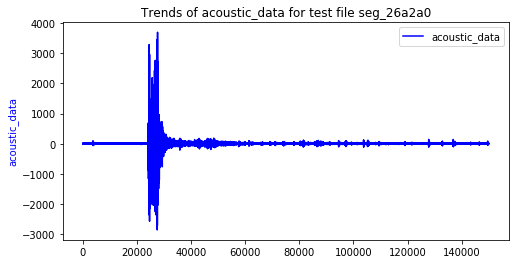

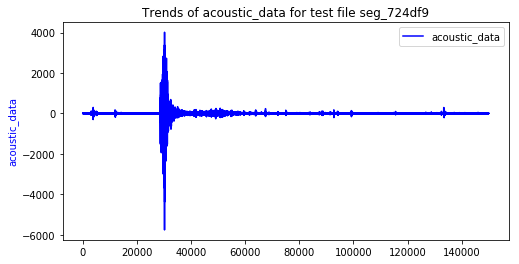

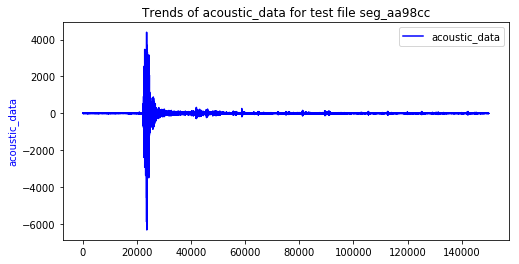

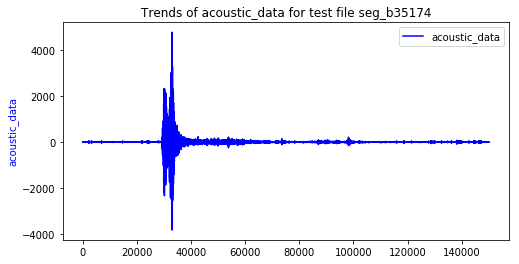

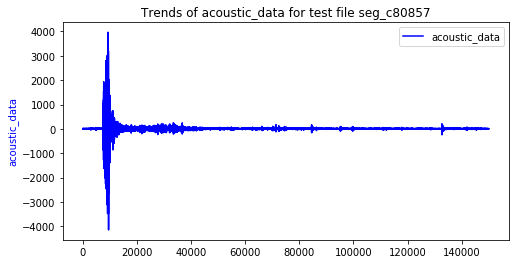

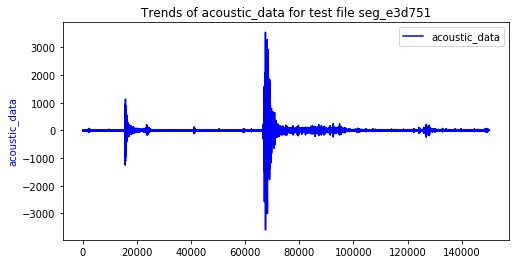

In [67]:
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
segments = possible_eq["seg_id"]
print(segments)
# segments = ["seg_26a2a0", "seg_724df9", "seg_7a9f2b", "seg_7fa6ec", "seg_aa98cc", "seg_b35174", "seg_c80857", "seg_e3d751"]

for seg_id in segments:
    print(seg_id)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])


The above plots of the acoustic_data values for all the test files (each containing 150,000 samples) that were predicted with a time_to_failure of < 1.0 show a massive peak in the acoustic_data values, in the range of 3000-6000. This observation is in line with the trend also observed in the input data sample where each of the 16 earthquakes (time_to_failure=0) were preceded by a massive spike just before the occurrence of the earthquake (refer to Figure). 
